Demonstration : An adaptive rag that includes web search and vector store search - based on context of query it decides to what to do next

In [9]:
import os
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")
os.environ["TAVILY_API_KEY"]=os.getenv("TAVILY_API_KEY")

In [10]:
from langchain_huggingface import HuggingFaceEmbeddings

# Intializing a simple Hugging face model without any api key
embeddings = HuggingFaceEmbeddings(
    model_name="sentence-transformers/all-mpnet-base-v2"
)

In [11]:
# Building the vector store 

from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import FAISS


# Docs to index - examples
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

# Load
docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

# Split
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=500, chunk_overlap=50
)
doc_splits = text_splitter.split_documents(docs_list)

# Add to vectorstore
vectorstore=FAISS.from_documents(
    documents=doc_splits,
    embedding=embeddings
)


retriever=vectorstore.as_retriever()

In [12]:
### Router

from typing import Literal

from langchain_core.prompts import ChatPromptTemplate
from langchain.chat_models import init_chat_model
llm=init_chat_model("groq:meta-llama/llama-4-scout-17b-16e-instruct")

from pydantic import BaseModel, Field

# Data model
class RouteQuery(BaseModel):
     


    datasource: Literal["vectorstore", "web_search"] = Field(
        ...,
        description="Given a user question choose to route it to web search or a vectorstore.",
    )

# LLM with function call

structured_llm_router = llm.with_structured_output(RouteQuery)
system = """
You MUST follow these rules strictly.

Route to vectorstore ONLY if the question is explicitly about:
- LLM agents
- prompt engineering
- adversarial attacks on language models
- RAG, retrieval, or agent memory

If the question is about:
- animals
- physics
- biology
- people
- general knowledge
- "why" questions unrelated to LLMs

You MUST choose web_search.

If unsure, choose web_search.
"""

route_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{question}"),
    ]
)

question_router = route_prompt | structured_llm_router

print(
    question_router.invoke(
        {"question": "What is the current networth of Elon Musk"}
    )
)


datasource='web_search'


In [13]:
print(question_router.invoke({"question": "What are the types of agent memory?"}))

datasource='vectorstore'


In [14]:
### Retrieval Grader


# Data model
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )


# LLM with function call

structured_llm_grader = llm.with_structured_output(GradeDocuments)

# Prompt
system = """You are a grader assessing relevance of a retrieved document to a user question. \n 
    If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
    It does not need to be a stringent test. The goal is to filter out erroneous retrievals. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

retrieval_grader = grade_prompt | structured_llm_grader
question = "agent memory"
## context
docs = retriever.invoke(question)
doc_txt = docs[1].page_content
print(retrieval_grader.invoke({"question": question, "document": doc_txt}))

binary_score='yes'


In [15]:
import os
os.environ["LANGSMITH_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")
from langsmith import Client

client = Client()

### The thing that is pulled from langsmith hub through rlm/rag-prompt : 
You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: {question} 
Context: {context} 
Answer:

In [16]:
### Generate


from langchain_core.output_parsers import StrOutputParser

# Prompt
prompt = client.pull_prompt("rlm/rag-prompt")




# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


# Chain
rag_chain = prompt | llm | StrOutputParser()

# Run
generation = rag_chain.invoke({"context": docs, "question": question})
print(generation)

In a LLM-powered autonomous agent system, the agent's memory consists of short-term memory, which utilizes in-context learning to learn, and long-term memory, which retains and recalls infinite information over extended periods using an external vector store and fast retrieval. The long-term memory provides the agent with the capability to retain and recall information over extended periods. I don't have more information about other aspects of agent memory.


In [17]:
### Hallucination Grader


# Data model
class GradeHallucinations(BaseModel):
    """Binary score for hallucination present in generation answer."""

    binary_score: str = Field(
        description="Answer is grounded in the facts, 'yes' or 'no'"
    )


# LLM with function call

structured_llm_grader = llm.with_structured_output(GradeHallucinations)

# Prompt
system = """You are a grader assessing whether an LLM generation is grounded in / supported by a set of retrieved facts. \n 
     Give a binary score 'yes' or 'no'. 'Yes' means that the answer is grounded in / supported by the set of facts."""
hallucination_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Set of facts: \n\n {documents} \n\n LLM generation: {generation}"),
    ]
)

hallucination_grader = hallucination_prompt | structured_llm_grader
hallucination_grader.invoke({"documents": docs, "generation": generation})

GradeHallucinations(binary_score='yes')

In [18]:
# Answer Grader


# Data model
class GradeAnswer(BaseModel):
    """Binary score to assess answer addresses question."""

    binary_score: str = Field(
        description="Answer addresses the question, 'yes' or 'no'"
    )


# LLM with function call

structured_llm_grader = llm.with_structured_output(GradeAnswer)

# Prompt
system = """You are a grader assessing whether an answer addresses / resolves a question \n 
     Give a binary score 'yes' or 'no'. Yes' means that the answer resolves the question."""
answer_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "User question: \n\n {question} \n\n LLM generation: {generation}"),
    ]
)

answer_grader = answer_prompt | structured_llm_grader
answer_grader.invoke({"question": question, "generation": generation})

GradeAnswer(binary_score='yes')

In [19]:
### Question Re-writer



# Prompt
system = """
Rewrite the question to improve vectorstore retrieval.

STRICT RULES:
- Output ONE single sentence
- NO explanations
- NO markdown
- NO quotes
- NO prefixes
- NO suffixes

Only return the rewritten question.
"""

re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human",
            "Here is the initial question: \n\n {question} \n Formulate an improved question.",
        ),
    ]
)

question_rewriter = re_write_prompt | llm.bind(stop=["\n"]) | StrOutputParser()

question_rewriter.invoke({"question": question})

"What are the capabilities and limitations of an agent's memory in artificial intelligence systems?"

In [20]:
### Search

from langchain_community.tools.tavily_search import TavilySearchResults

web_search_tool = TavilySearchResults(k=3)

/var/folders/qt/64kxbqr16ps6hbrf1lzxq5dc0000gn/T/ipykernel_59700/730760015.py:5: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the `langchain-tavily package and should be used instead. To use it run `pip install -U `langchain-tavily` and import as `from `langchain_tavily import TavilySearch``.
  web_search_tool = TavilySearchResults(k=3)


In [21]:
web_search_tool.invoke("latest news about AI")

[{'title': 'Latest AI News and AI Breakthroughs that Matter Most',
  'url': 'https://www.crescendo.ai/news/latest-ai-news-and-updates',
  'content': 'Date: December 25, 2025\n\nSummary: China has achieved significant advances in its artificial intelligence (AI) sector, with more than 700 generative AI large model products having completed official filing procedures, according to the Cyberspace Administration of China (CAC). These filings reflect breakthroughs in AI, integrated circuits, and basic software throughout the 14th Five-Year Plan period (2021–25). Alongside this progress, China’s IT applications have expanded widely, boosting internet penetration and bridging the urban-rural digital divide. Growth in areas such as rural online retail and telemedicine underscores the deepening integration of AI and digital technologies into everyday life and industrial use.\n\nSource: China Daily [...] Date: October 26, 2025  \nSummary: Tesla, Inc. unveiled significant updates to its humanoid 

In [22]:
from typing import List

from typing_extensions import TypedDict


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        documents: list of documents
    """

    question: str
    generation: str
    documents: List[str]

In [30]:
from langchain_core.documents import Document


def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    documents = retriever.invoke(question)
    return {"documents": documents, "question": question}


def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]

    # FIX for unknown  Defensive generation
    if not documents:
        return {
            "generation": "I don’t have relevant documents to answer this question.",
            "question": question,
            "documents": documents,
        }

    # RAG generation
    generation = rag_chain.invoke(
        {"context": documents, "question": question}
    )

    return {
        "documents": documents,
        "question": question,
        "generation": generation,
    }



def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": d.page_content}
        )
        grade = score.binary_score
        if grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            continue
    return {"documents": filtered_docs, "question": question}


def transform_query(state):
    system = """
Rewrite the question to improve vectorstore retrieval.

STRICT RULES:
- Output ONE single sentence
- NO explanations
- NO markdown
- NO quotes
- NO prefixes
- NO suffixes

Only return the rewritten question.
"""


    print("---TRANSFORM QUERY---")
    question = state["question"]
    documents = state["documents"]

    # Re-write question
    better_question = question_rewriter.invoke({"question": question})
    return {"documents": documents, "question": better_question}


def web_search(state):
    """
    Web search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    print("---WEB SEARCH---")
    question = state["question"]

    # Web search
    docs = web_search_tool.invoke({"query": question})
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)

    return {"documents": [web_results], "question": question}


### Edges ###


def route_question(state):
    system = """
You MUST follow these rules strictly.

Route to vectorstore ONLY if the question is explicitly about:
- LLM agents
- prompt engineering
- adversarial attacks on language models
- RAG, retrieval, or agent memory

If the question is about:
- animals
- physics
- biology
- people
- general knowledge
- "why" questions unrelated to LLMs

You MUST choose web_search.

If unsure, choose web_search.
"""


    print("---ROUTE QUESTION---")
    question = state["question"]
    source = question_router.invoke({"question": question})
    LLM_TOPICS = ["agent", "prompt", "llm", "retrieval", "rag", "adversarial"]

    if any(t in question.lower() for t in LLM_TOPICS):
        print("---ROUTE QUESTION TO RAG---")
        return "vectorstore"

    print("---ROUTE QUESTION TO WEB SEARCH---")
    return "web_search"
    # if source.datasource == "web_search":
    #     print("---ROUTE QUESTION TO WEB SEARCH---")
    #     return "web_search"
    # elif source.datasource == "vectorstore":
    #     print("---ROUTE QUESTION TO RAG---")
    #     return "vectorstore"


def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    state["question"]
    filtered_documents = state["documents"]

    if not filtered_documents:
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---"
        )
        return "web_search"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"


def grade_generation_v_documents_and_question(state):
    """
    Determines whether the generation is grounded in the document and answers question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """

    print("---CHECK HALLUCINATIONS---")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]

    score = hallucination_grader.invoke(
        {"documents": documents, "generation": generation}
    )
    grade = score.binary_score

    # Check hallucination
    if grade == "yes":
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        # Check question-answering
        print("---GRADE GENERATION vs QUESTION---")
        score = answer_grader.invoke({"question": question, "generation": generation})
        grade = score.binary_score
        if grade == "yes":
            print("---DECISION: GENERATION ADDRESSES QUESTION---")
            return "useful"
        else:
            print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
            return "not useful"
    else:
        print("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "not supported"

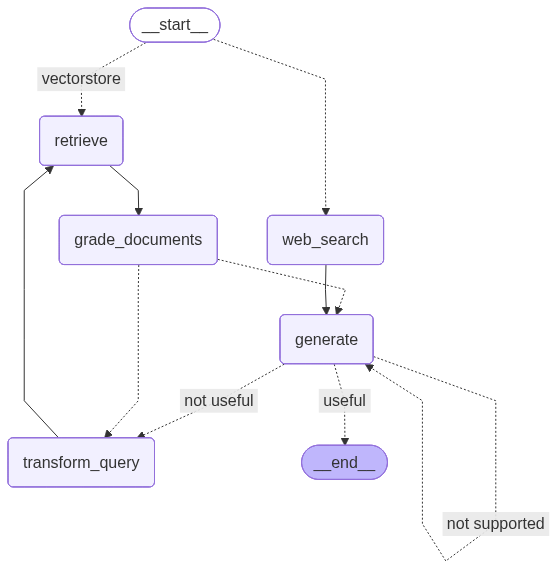

In [31]:
from langgraph.graph import END, StateGraph, START

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("web_search", web_search)  # web search
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generate
workflow.add_node("transform_query", transform_query)  # transform_query

# Build graph
workflow.add_conditional_edges(
    START,
    route_question,
    {
        "web_search": "web_search",
        "vectorstore": "retrieve",
    },
)
workflow.add_edge("web_search", "generate")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "transform_query": "transform_query",
        "generate": "generate",
    },
)
workflow.add_edge("transform_query", "retrieve")
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",
        "useful": END,
        "not useful": "transform_query",
    },
)

# Compile
app = workflow.compile()
app

In [33]:
app.invoke({"question":"Why do birds fly"}) # this context is not given in vector store

---ROUTE QUESTION---
---ROUTE QUESTION TO WEB SEARCH---
---WEB SEARCH---
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---


{'question': 'Why do birds fly',
 'generation': 'Birds fly when the forces they create, specifically lift and thrust, are greater than the forces acting upon them, namely weight and drag. They use their wings to create these physical forces that allow them to fly, with lift being the vertical force that keeps them aloft and thrust propelling them forward. This is made possible by their lightweight bodies, well-developed chest muscles, and specially shaped feathers.',
 'documents': [Document(metadata={}, page_content='Even if you attached wings to yourself with the hope of flying, you unfortunately would not be able to. That is because the secret to how birds fly is not only in their feathers but also in their body.  \nFirstly, there are the muscles. The muscles in the chest required for a bird to flap its wings are very well developed. In some birds, the muscles in the chest alone account for more than one quarter of its body weight. (The proportion in humans is said to be one one-hund

In [28]:
app.invoke({"question":"How dogs drink water"}) # this context is not given in vector store

---ROUTE QUESTION---
---WEB SEARCH---
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---


{'question': 'How dogs drink water',
 'generation': 'Dogs drink water by curling their tongues backward, shaping like a ladle, and scooping water, which creates a column of water that feeds into their mouths. As they take their tongues out of the water, they create an acceleration of roughly five times that of gravity. The dog then closes its mouth around the top of the water column to maximize the amount of liquid.',
 'documents': Document(metadata={}, page_content="Until the next year, when Harvard researchers X-rayed dogs drinking and realized that they were doing what cats did — albeit in a messier way. “We conclude that cats and dogs share the same basic mechanism,” they wrote. “Liquid adheres to the dorsal surface of the backwardly curled tongue tip.”\n\nWhat about the water the dog scoops into its backwards ladle? That water ends up underneath the dog’s tongue — a problem for pooches, since water must be above the tongue to be swallowed. “For humans, if you have water underneath

In [34]:
app.invoke({"question":"What is agent memory"}) # relevant to vectorstore

---ROUTE QUESTION---
---ROUTE QUESTION TO RAG---
---RETRIEVE---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: GENERATE---
---GENERATE---
---CHECK HALLUCINATIONS---
---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---
---GRADE GENERATION vs QUESTION---
---DECISION: GENERATION ADDRESSES QUESTION---


{'question': 'What is agent memory',
 'generation': 'Agent memory refers to the capability of an LLM-powered autonomous agent to retain and recall information. It consists of two types: short-term memory, which utilizes in-context learning to learn, and long-term memory, which provides the agent with the capability to retain and recall infinite information over extended periods, often by leveraging an external vector store and fast retrieval.',
 'documents': [Document(id='9c8ed01a-c64f-4b04-9a50-1cc39d1a9d35', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general probl